In [1]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np

def fill_timing_data(df, df_err, num_push_procs, num_pop_procs, num_pipes):
    
    time_taken_push_procs =  [0.0 for _ in range(3)]
    time_taken_pop_procs =  [0.0 for _ in range(3)]    
    ttc = [0.0 for _ in range(3)]
    mem_cons = [0.0 for _ in range(3)]
    base_mem_cons = [0.0 for _ in range(3)]
        
    for i in range(3):
    
        DATA = './push_%s_pop_%s_p_%s_trial_%s'%(num_push_procs, num_pop_procs, num_pipes,i)
    
        push_data = glob.glob('%s/push*.txt'%DATA)
    
        min_push = 0.0
        max_push = 0.0
    
        for f1 in push_data:
        
            f = open(f1,'r')        
            lines = f.readlines()
            f.close()
        
            base_mem_cons[i] += float(lines[0].strip().split(' ')[1].strip())
            for line in lines:
            
                cur_time = float(line.strip().split(' ')[0].strip())
            
                if min_push == 0.0:
                    min_push = cur_time
                    max_push = cur_time
                
                if cur_time < min_push:
                    min_push = cur_time
                    
                if cur_time > max_push:
                    max_push = cur_time
    
            mem_cons[i] += float(line.strip().split(' ')[1].strip())
    
        pop_data = glob.glob('%s/pop*.txt'%DATA)
        
        min_pop = 0.0
        max_pop = 0.0
    
        for f1 in pop_data:
        
            f = open(f1,'r')        
            lines = f.readlines()
            f.close()
        
            base_mem_cons[i] += float(lines[0].strip().split(' ')[1].strip())
            for line in lines:
            
                cur_time = float(line.strip().split(' ')[0].strip())
            
                if min_pop == 0.0:
                    min_pop = cur_time
                    max_pop = cur_time
                
                if cur_time < min_pop:
                    min_pop = cur_time
                if cur_time > max_pop:
                    max_pop = cur_time
                    
            mem_cons[i] += float(line.strip().split(' ')[1].strip())
                
        time_taken_push_procs[i] =  max_push - min_push
        time_taken_pop_procs[i] =  max_pop - min_pop    
        ttc[i] = max(max_pop,max_push) - min(min_pop, min_push)
        
    vals = [np.mean(time_taken_push_procs), 
            np.mean(time_taken_pop_procs),
            np.mean(ttc),
            np.mean(mem_cons),
            np.mean(base_mem_cons)]
    
    #print df.loc['%s,%s,%s'%(num_push_procs, num_pop_procs, num_queues)]
    df.loc['%s,%s,%s'%(num_push_procs, num_pop_procs, num_pipes)] = vals
    
    vals = [np.std(time_taken_push_procs), 
            np.std(time_taken_pop_procs),
            np.std(ttc),
            np.std(mem_cons),
            np.std(base_mem_cons)]
    
    df_err.loc['%s,%s,%s'%(num_push_procs, num_pop_procs, num_pipes)] = vals
    
    return df, df_err

In [4]:
#TTC
num_procs_list = [1,2,4,8,16,32]

cols = ['Time taken for all push procs','Time taken for all pop procs','TTC', 'Total Peak memory consumption','Total Baseline memory consumption']
index = ['%s,%s,%s'%(i,i,i) for i in num_procs_list]

df = pd.DataFrame(columns=cols, index=index)
df_err = pd.DataFrame(columns=cols, index=index)

for num_push_procs in num_procs_list:
    num_pop_procs = num_push_procs
    num_pipes = num_push_procs
    df, df_err = fill_timing_data(df, df_err, num_push_procs, num_pop_procs, num_pipes)

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

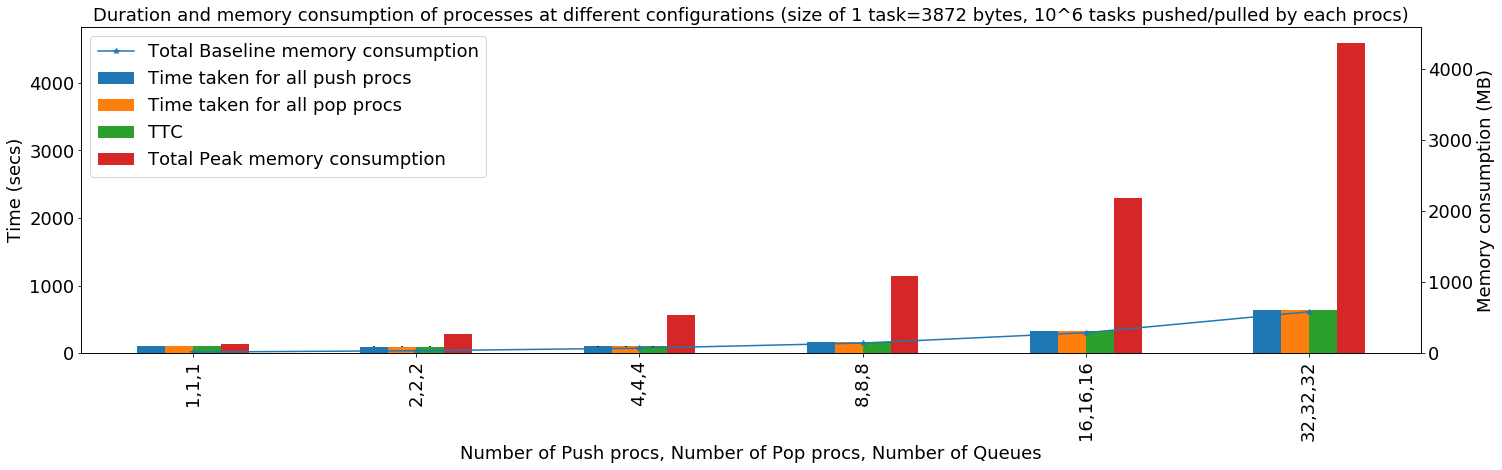

In [11]:
#print df
#print df_err

FONTSIZE=18

fig,ax = plt.subplots(1,1)
fig.set_size_inches(24,6)

df3 = df['Total Baseline memory consumption']
ax3 = df3.plot(ax=ax,use_index=True,kind='line',marker='*')

ax1 = df.plot(ax=ax, kind='bar', y=['Time taken for all push procs','Time taken for all pop procs','TTC', 'Total Peak memory consumption'],
              yerr=df_err,fontsize=FONTSIZE,
              title='Duration and memory consumption of processes at different configurations (size of 1 task=3872 bytes, 10^6 tasks pushed/pulled by each procs)', use_index = True)

df2 = pd.DataFrame(columns=['Total Peak memory consumption'], index=df.index)
ax2 = df2.plot(ax=ax, kind='bar', secondary_y=True, use_index=True)

ax1.set_xlabel('Number of Push procs, Number of Pop procs, Number of Queues',fontsize=FONTSIZE)
ax1.set_ylabel('Time (secs)',fontsize=FONTSIZE)
ax1.set_title(ax1.get_title(),fontsize=FONTSIZE)
ax2.set_ylabel('Memory consumption (MB)',fontsize=FONTSIZE)
ax2.set_ylim(0,df['Total Peak memory consumption'].max())

patches, labels = ax1.get_legend_handles_labels()

ax1.legend(patches, labels, loc='best',fontsize=FONTSIZE)
plt.yticks(size=FONTSIZE)
plt.xticks(rotation=0)